In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gammaincc
from scipy.stats import pearsonr
import scipy.stats as stats
from scipy.stats import norm
import emcee
import multiprocessing
import random
import time
import threading

# Numerical astrophysics, Exam 2 - part II
### February 3rd


## Exercise 1 (10 points)

Please implement the upstream differencing scheme for solving the 1D advection equation:

$$\frac{\partial q}{\partial t} + c \frac{\partial q}{\partial x} = 0,$$

where $q(x,t)$ represents the advected quantity and $c$ is the constant advection velocity. The initial condition is given as a Gaussian pulse and the boundary conditions are periodic. Use the following parameters:

- domain length: L = 1.0
- number of grid points: N = 200
- advection velocity: c = 1.0
- total simulation time: T = 0.2
- initial condition:
  
  $$q(x,0) = exp\left(-\frac{(x - 0.5)^2}{2\sigma^2}\right),$$

where $\sigma = 0.1$

In this exercise, implement your own Python code and verify the results and plot the initial and final solution profiles on the same graph.

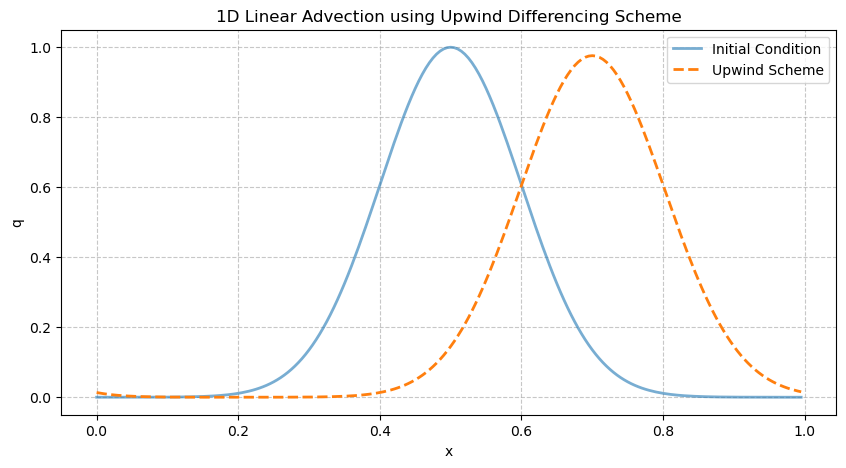

In [3]:

def define_spatial_domain(L=1.0, N=200):
    """    Defines the spatial domain for the PDE.
    L : float
        Length of the domain.
    N : int
        Number of grid points.
    -------Returns---------
    x : ndarray
        Array of x-coordinates (cell centers).
    dx : float
        Spatial resolution (distance between grid points).
    """
    x = np.linspace(0, L, N, endpoint=False)
    dx = L / N
    return x, dx


def define_time_step(dx, c=1.0, cfl=0.5, total_time=0.2):
    """    Defines the time step from a CFL condition and
    calculates the number of steps.
    dx : float
        Spatial resolution.
    c : float
        Advection speed.
    cfl : float
        Desired CFL number.
    total_time : float
        Total simulation time.
    -------Returns---------
    dt : float
        Time step size.
    n_steps : int
        Number of time steps to cover total_time.
    """
    dt = cfl * dx / c  
    n_steps = int(total_time / dt)
    return dt, n_steps


def initial_condition_step(x, sigma=0.1):

    q0 = np.zeros_like(x)
    q0 = np.exp(-(x-0.5)**2 / (2*(sigma**2)))
    return q0


def upwind_step(q, c, dt, dx):
    """    Performs one time step of the upwind (upstream) scheme for the 1D advection equation
    q_t + c*q_x = 0, with periodic boundary conditions.
    q : ndarray
        Current solution array of shape (N,).
    c : float
        Advection speed.
    dt : float
        Time step size.
    dx : float
        Spatial resolution.
    -------Returns---------
    q_new : ndarray
        Updated solution array after one upwind step.
    """
    N = len(q)
    q_new = q.copy()

    # Upwind differencing for interior points
    # q_{i}^{n+1} = q_{i}^{n} - (c * dt / dx) * [q_{i}^{n} - q_{i-1}^{n}]
    for i in range(1, N):
        q_new[i] = q[i] - (c * dt / dx) * (q[i] - q[i-1])

    # Periodic boundary condition for i = 0 
    # (using q[-1] as the "left neighbor")
    q_new[0] = q[0] - (c * dt / dx) * (q[0] - q[-1])

    return q_new


def solve_advection_1D_upwind(x, q0, c, dt, n_steps):
    """    Solves the 1D advection equation using an upwind scheme.
    x : ndarray
        Spatial coordinates.
    q0 : ndarray
        Initial condition.
    c : float
        Advection speed.
    dt : float
        Time step size.
    n_steps : int
        Number of time steps.
    -------Returns---------
    q : ndarray
        Numerical solution at the final time step.
    """
    q = q0.copy()
    dx = x[1] - x[0]
    for _ in range(n_steps):
        q = upwind_step(q, c, dt, dx)
    return q


def main():

    L = 1.0
    N = 200
    c = 1.0
    total_time = 0.2
    cfl = 0.5

    x, dx = define_spatial_domain(L=L, N=N)

    dt, n_steps = define_time_step(dx, c=c, cfl=cfl, total_time=total_time)
    
    # initial condition
    q0 = initial_condition_step(x, sigma=0.1)
    
    
    q_final = solve_advection_1D_upwind(x, q0, c, dt, n_steps)
    
    # 5. Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(x, q0, label='Initial Condition', linewidth=2, alpha=0.6)
    plt.plot(x, q_final, label='Upwind Scheme', linewidth=2, ls='--')
    plt.xlabel('x')
    plt.ylabel('q')
    plt.title('1D Linear Advection using Upwind Differencing Scheme')
    plt.legend()
    plt.grid(alpha=0.7, linestyle='--')
    plt.show()


if __name__ == "__main__":
    main()

## Exercise 2 (10 points)

Using the DSMC method, calculate the surface area under the Gaussian pulse curve used as an initial condition in the previous exercise. To do so, launch particles randomly within a defined domain and calculate the fraction of particles that land under the curve compared to those above it.

The Gaussian pulse is defined as above:

$$f(x) = exp\left(-\frac{(x - 0.5)^2}{2\sigma^2}\right),$$

where:
- $x_0 = 0.5$ is the center of the pulse
- $\sigma = 0.1$ is the standard deviation of the pulse.

You can use the domain size of $x \in [0,1], y \in [0,1]$. The range of $f(x)$ is approximately $[0,1]$ inside this domain. Generate a sufficiently high number of particles$N_p$ with random positions $x_p \in [0,1]$ and random heights $y_p \in [0,1]$. Use the fraction of particles under the curve to estimate the area. 

Your code should output the area under the curve and include a plot of the Gaussian curve with particles for an $N_p$ of your choice.

Estimated area under the curve: 0.2506843


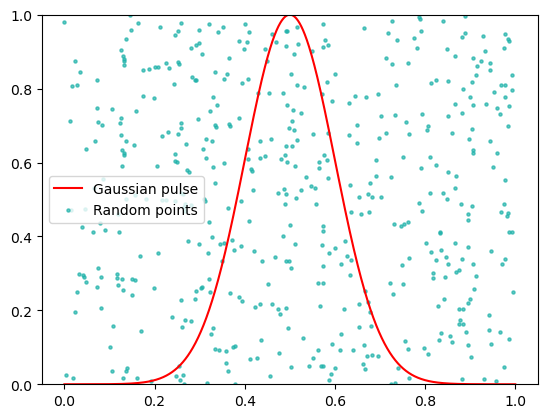

In [7]:

N = 10000000 # number of particles

def pulse(x):
    return np.exp(-((x - 0.5)**2)/(2*(0.1**2)))


x_min, x_max = 0, 1
y_min, y_max = 0, 1
x_rand = np.random.uniform(x_min, x_max, N)
y_rand = np.random.uniform(y_min, y_max, N)

under = (y_rand < pulse(x_rand))
area_est = np.sum(under) / N 

print("Estimated area under the curve:", area_est)

x_plot = np.linspace(0,1,2000)
plt.plot(x_plot, pulse(x_plot), 'r', label='Gaussian pulse')
plt.scatter(x_rand[:500], y_rand[:500], s=5, alpha=0.7, color='lightseagreen', label='Random points')
plt.ylim(0,1)
plt.legend()
plt.show()
